# Training a second model

In this notebook, I train a second model using features in order to address the first model's shortcomings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import format_raw_df

np.random.seed(35)

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

df = df.loc[df["is_question"]].copy()

In [2]:
from ml_editor.data_processing import get_split_by_author

df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")

Let's add new features we've identified as potential candidates in our new model.

In [3]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from ml_editor.data_processing import train_vectorizer, get_vectorized_series


vectorizer = train_vectorizer(train_df)
df["vectors"] = get_vectorized_series(df["full_text"].copy(), vectorizer)

Check out the ml_editor source code to see more about what these functions are doing!

In [5]:
from ml_editor.model_v2 import add_char_count_features, get_word_stats, get_sentiment_score

df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/emmanuel.ameisen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 7971/7971 [00:20<00:00, 386.87it/s]


In [6]:
from ml_editor.model_v2 import POS_NAMES

feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

# Model

Now that we've added new features, let's train a new model. We'll use the same model as before, only the features are different.

In [7]:
# We split again since we have now added all features. 
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [8]:
from ml_editor.data_processing import get_feature_vector_and_label

X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [9]:
y_train.value_counts()

False    3483
True     2959
Name: Score, dtype: int64

In [10]:
X_test.shape

(1529, 7799)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

Now, we can measure performance as we saw in the first training notebook.

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1



# Training accuracy
# Thanks to https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Training accuracy = 0.597, precision = 0.577, recall = 0.461, f1 = 0.513


In [13]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Validation accuracy = 0.618, precision = 0.632, recall = 0.524, f1 = 0.573


Fortunately, this model shows stronger aggregate performance then are previous model! Let's save our new model and vectorizer to disk so we can use it later.

In [14]:
from sklearn.externals import joblib

model_path = Path("../models/model_2.pkl")
vectorizer_path = Path("../models/vectorizer_2.pkl")
joblib.dump(clf, model_path) 
joblib.dump(vectorizer, vectorizer_path) 

['../models/vectorizer_2.pkl']

## Validating that features are useful

Next, we'll look at feature importances to validate that our new features are being used by the new model.

In [15]:
from ml_editor.model_evaluation import get_feature_importance

w_indices = vectorizer.get_feature_names()
w_indices.extend(feature_arr)
all_feature_names = np.array(w_indices)

In [16]:
k = 20
print("Top %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\nBottom %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

Top 20 importances:

num_questions: 0.0078
num_periods: 0.0078
num_chars: 0.0078
num_diff_words: 0.0078
DET: 0.0072
ADJ: 0.007
ADV: 0.0068
num_commas: 0.0067
NOUN: 0.0065
VERB: 0.0063
PUNCT: 0.0063
num_words: 0.0062
avg_word_len: 0.0061
ADP: 0.0061
num_stops: 0.0061
PRON: 0.006
PART: 0.0058
are: 0.0056
polarity: 0.0055
PROPN: 0.0047

Bottom 20 importances:

enthusiastic: 0
soviet: 0
calmly: 0
omitted: 0
bundle: 0
officials: 0
envelope: 0
cake: 0
environments: 0
cafeteria: 0
sped: 0
odyssey: 0
er: 0
erased: 0
obtaining: 0
spinning: 0
obsessed: 0
observations: 0
est: 0
00: 0


Our new features are amongst the most predictive!

## Comparing predictions to data

This section uses the evaluation methods described in the `Comparing Data To Predictions` notebook, but on our new model.

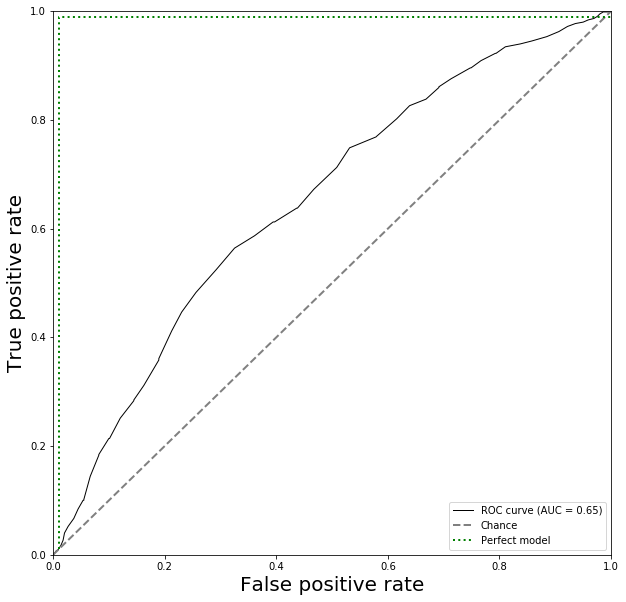

In [17]:
from ml_editor.model_evaluation import get_roc_plot


get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

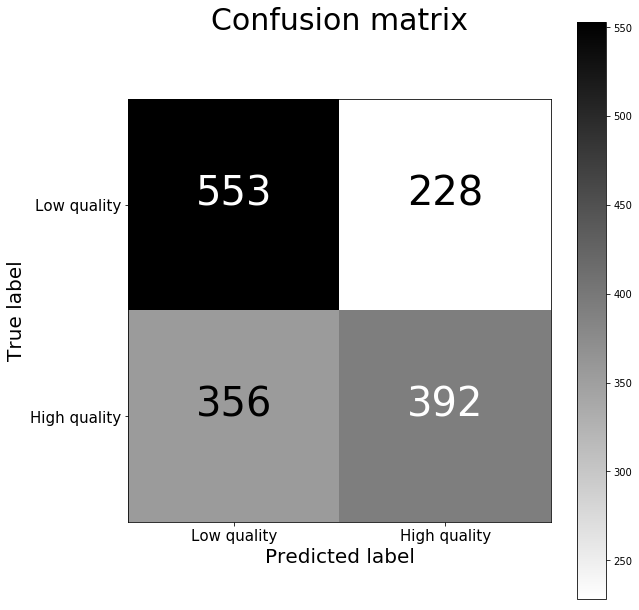

In [18]:
from ml_editor.model_evaluation import get_confusion_matrix_plot

%load_ext autoreload
%autoreload 2


get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))


No handles with labels found to put in legend.


	Brier: 0.234


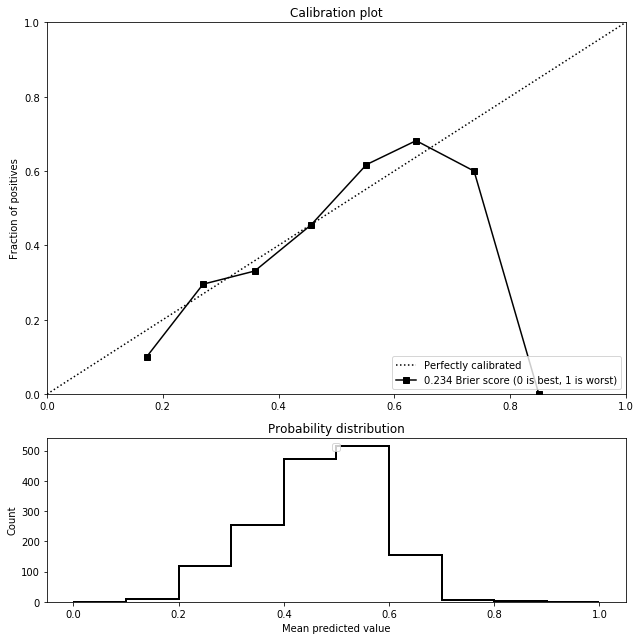

In [19]:
from ml_editor.model_evaluation import get_calibration_plot

get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

## Inference Function

Just like for our first model, we define an inference function that takes in an arbitrary question and outputs an estimated probability of it receiving a high score according to our model.

In [20]:
from ml_editor.model_v2 import get_question_score_from_input
    
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████| 1/1 [00:00<00:00, 629.30it/s]

0.36 probability of the question receiving a high score according to our model
